<a href="https://colab.research.google.com/github/abhiyantaabhishek/test/blob/main/Test_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive and  get the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!unzip /content/drive/MyDrive/Test_data.zip

In [3]:
!ls Test_data/

Test  Train  Val


In [ ]:
!mv Test_data/Sample_Submission.csv Sample_Submission.csv

# Import the libs

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix
import cv2

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ( EarlyStopping, ModelCheckpoint,ReduceLROnPlateau)
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow as tf

# Data Preprocessing

In [7]:
classess = os.listdir("Test_data/Train/")
classess

['car', 'animal', 'truck', 'human', 'airplane']

In [8]:
for class_ in classess:
  img_path = os.path.join("Test_data/Train/",class_)
  print( "No of Img Train:", len(os.listdir(img_path)),',',class_)

No of Img Train: 194 , car
No of Img Train: 194 , animal
No of Img Train: 194 , truck
No of Img Train: 194 , human
No of Img Train: 194 , airplane


In [9]:
for class_ in classess:
  img_path = os.path.join("Test_data/Val/",class_)
  print( "No of Img Val:", len(os.listdir(img_path)),',',class_)

No of Img Val: 582 , car
No of Img Val: 582 , animal
No of Img Val: 582 , truck
No of Img Val: 582 , human
No of Img Val: 582 , airplane


In [10]:
train_images = []
train_labels = []
val_images = []
val_labels = []
test_images = []
test_labels = []
test_images_path =[]
for root, dirs, files in os.walk("Test_data"):
   for name in files:
      full_path = os.path.join(root, name)
      data_type = full_path.split(os.sep)[1]
      img = plt.imread(full_path)
      if(data_type == "Train"):
        label = full_path.split(os.sep)[2]
        train_images.append(img)
        train_labels.append(label)
      elif ( data_type == "Val"):
        label = full_path.split(os.sep)[2]
        val_images.append(img)
        val_labels.append(label)
      else:
        test_images.append(img)
        test_images_path.append(full_path)

In [11]:
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)
lb = LabelBinarizer()
lb.fit(train_labels)
print(lb.classes_)
train_label_onehot = lb.transform(train_labels)
val_label_onehot = lb.transform(val_labels)

['airplane' 'animal' 'car' 'human' 'truck']


In [12]:
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)
assert len(train_images) == len(train_labels)
assert len(val_images) == len(val_labels)

(970, 96, 96)
(2910, 96, 96)
(1940, 96, 96)


## Plot Hist

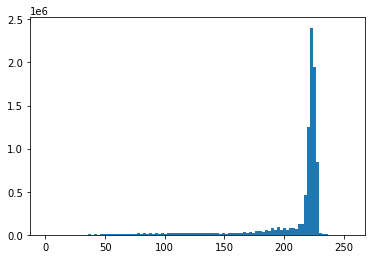

In [13]:
hist = plt.hist(train_images.flatten(),bins=100)

## Plot Images to visulise 

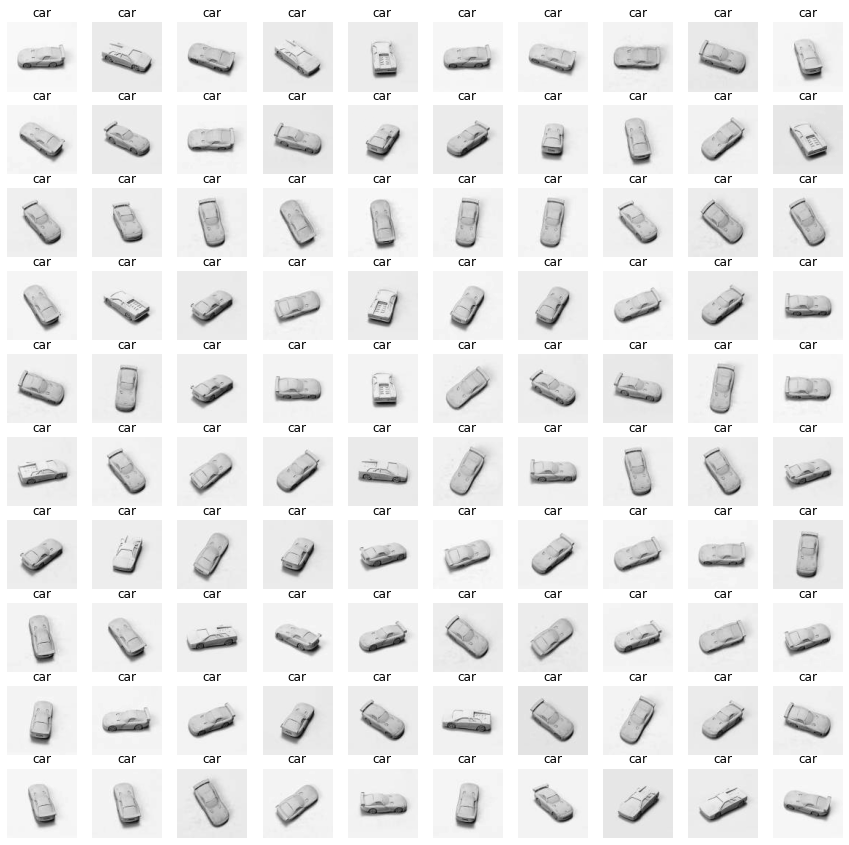

In [14]:
fig, axs = plt.subplots(10, 10,figsize=(15,15))

for i in range(10):
  for j in range(10):
    axs[i,j].imshow(train_images[i*10+j],cmap=plt.cm.gray)
    axs[i,j].set_title(lb.classes_[train_label_onehot[i*10+j].argmax()])
    axs[i,j].axis('off')


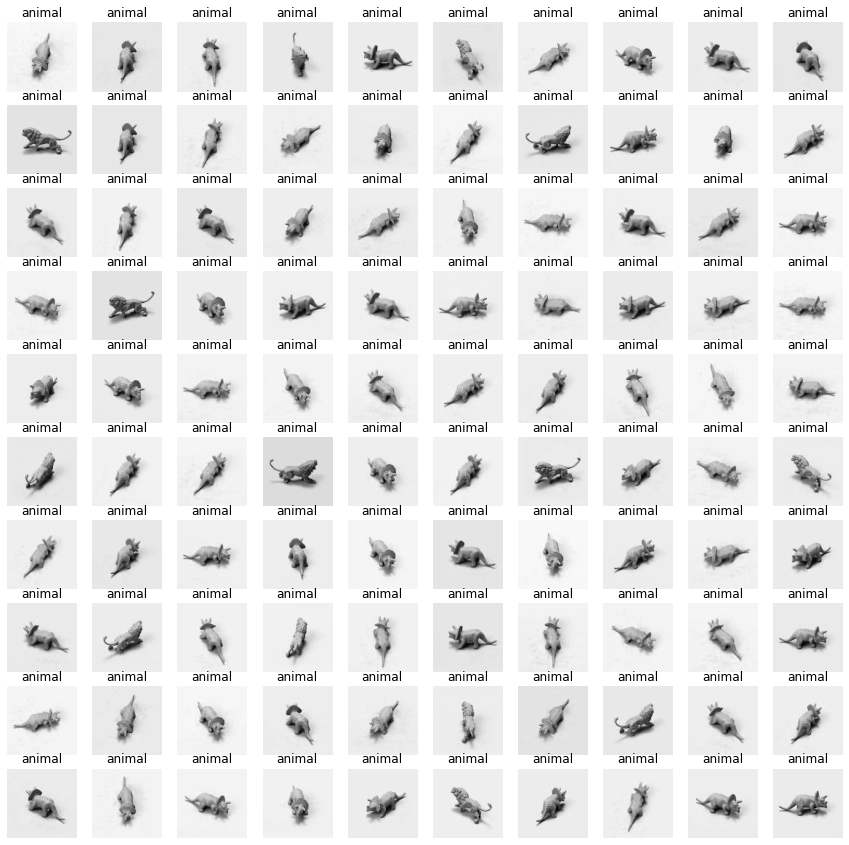

In [15]:
fig, axs = plt.subplots(10, 10,figsize=(15,15))

for i in range(10):
  for j in range(10):
    axs[i,j].imshow(train_images[200+i*10+j],cmap=plt.cm.gray)
    axs[i,j].set_title(lb.classes_[train_label_onehot[200+i*10+j].argmax()])
    axs[i,j].axis('off')


## Clear the Image to get proper view

In [16]:
for ind in range (len(train_images)):
  img = train_images[ind]
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
  opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
  train_images[ind] = opening
for ind in range (len(val_images)):
  img = val_images[ind]
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
  opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
  val_images[ind] = opening
for ind in range (len(test_images)):
  img = test_images[ind]
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
  opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
  test_images[ind] = opening

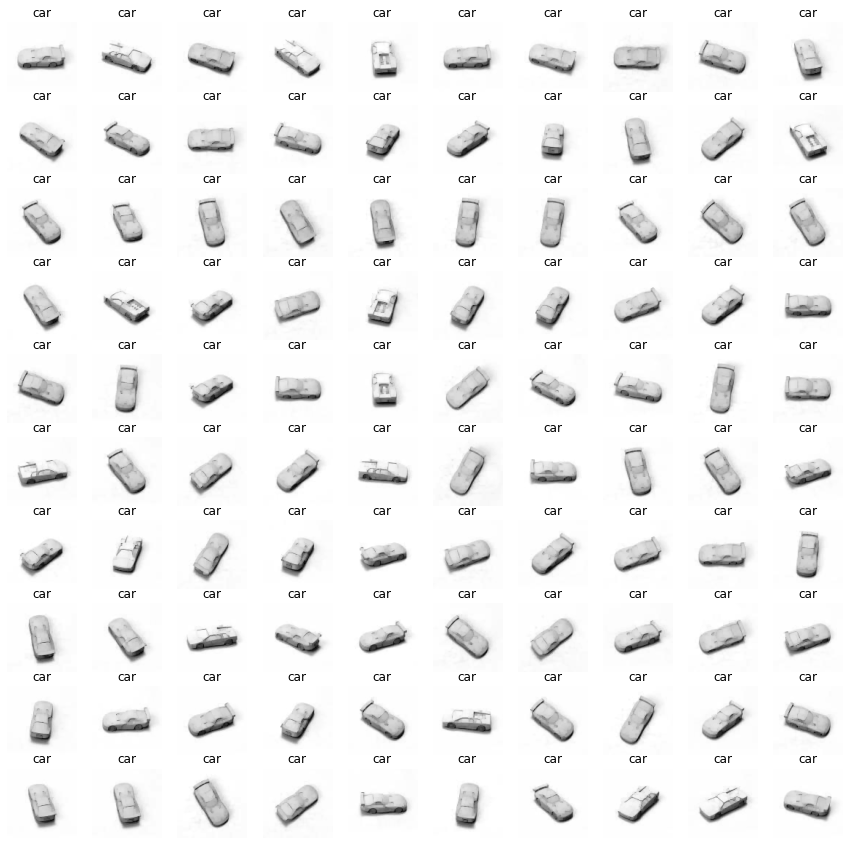

In [17]:
fig, axs = plt.subplots(10, 10,figsize=(15,15))

for i in range(10):
  for j in range(10):
    axs[i,j].imshow(train_images[i*10+j],cmap=plt.cm.gray)
    axs[i,j].set_title(lb.classes_[train_label_onehot[i*10+j].argmax()])
    axs[i,j].axis('off')

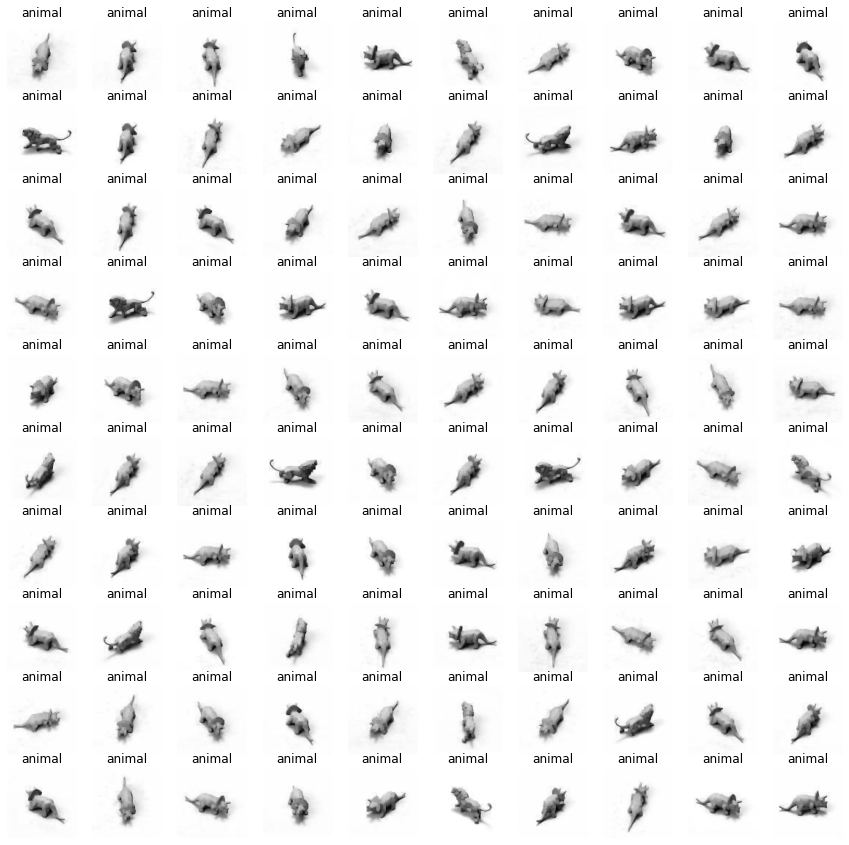

In [18]:
fig, axs = plt.subplots(10, 10,figsize=(15,15))

for i in range(10):
  for j in range(10):
    axs[i,j].imshow(train_images[200+i*10+j],cmap=plt.cm.gray)
    axs[i,j].set_title(lb.classes_[train_label_onehot[200+i*10+j].argmax()])
    axs[i,j].axis('off')


## Remove the unnecessary part of the image so that ROI becomes visible properly

In [19]:
w=10
for ind in range (len(train_images)):
  opening = train_images[ind]
  row_sum = np.arange(len(opening.sum(axis=0)>opening.sum(axis=0).mean()))[opening.sum(axis=0)<opening.sum(axis=0).mean()]
  col_sum = np.arange(len(opening.sum(axis=1)>opening.sum(axis=1).mean()))[opening.sum(axis=1)<opening.sum(axis=1).mean()]
  x_min = row_sum[0]-w if row_sum[0]-w>=0 else 0
  x_max = row_sum[-1]+w if row_sum[-1]+w<opening.shape[1] else opening.shape[1]-1 
  y_min = col_sum[0]-w  if col_sum[0]-w>=0 else 0
  y_max = col_sum[-1]+w if col_sum[-1]+w<opening.shape[0] else opening.shape[0]-1 
  opening = opening[y_min:y_max,x_min:x_max]  
  opening = cv2.resize(opening, (96, 96),interpolation = cv2.INTER_NEAREST)
  train_images[ind] = opening
for ind in range (len(val_images)):
  opening = val_images[ind]
  row_sum = np.arange(len(opening.sum(axis=0)>opening.sum(axis=0).mean()))[opening.sum(axis=0)<opening.sum(axis=0).mean()]
  col_sum = np.arange(len(opening.sum(axis=1)>opening.sum(axis=1).mean()))[opening.sum(axis=1)<opening.sum(axis=1).mean()]
  x_min = row_sum[0]-w if row_sum[0]-w>=0 else 0
  x_max = row_sum[-1]+w if row_sum[-1]+w<opening.shape[1] else opening.shape[1]-1 
  y_min = col_sum[0]-w  if col_sum[0]-w>=0 else 0
  y_max = col_sum[-1]+w if col_sum[-1]+w<opening.shape[0] else opening.shape[0]-1 
  opening = opening[y_min:y_max,x_min:x_max]  
  opening = cv2.resize(opening, (96, 96),interpolation = cv2.INTER_NEAREST)  
  val_images[ind] = opening
for ind in range (len(test_images)):
  opening = test_images[ind]
  row_sum = np.arange(len(opening.sum(axis=0)>opening.sum(axis=0).mean()))[opening.sum(axis=0)<opening.sum(axis=0).mean()]
  col_sum = np.arange(len(opening.sum(axis=1)>opening.sum(axis=1).mean()))[opening.sum(axis=1)<opening.sum(axis=1).mean()]
  x_min = row_sum[0]-w if row_sum[0]-w>=0 else 0
  x_max = row_sum[-1]+w if row_sum[-1]+w<opening.shape[1] else opening.shape[1]-1 
  y_min = col_sum[0]-w  if col_sum[0]-w>=0 else 0
  y_max = col_sum[-1]+w if col_sum[-1]+w<opening.shape[0] else opening.shape[0]-1 
  opening = opening[y_min:y_max,x_min:x_max]  
  opening = cv2.resize(opening, (96, 96),interpolation = cv2.INTER_NEAREST)  
  test_images[ind] = opening

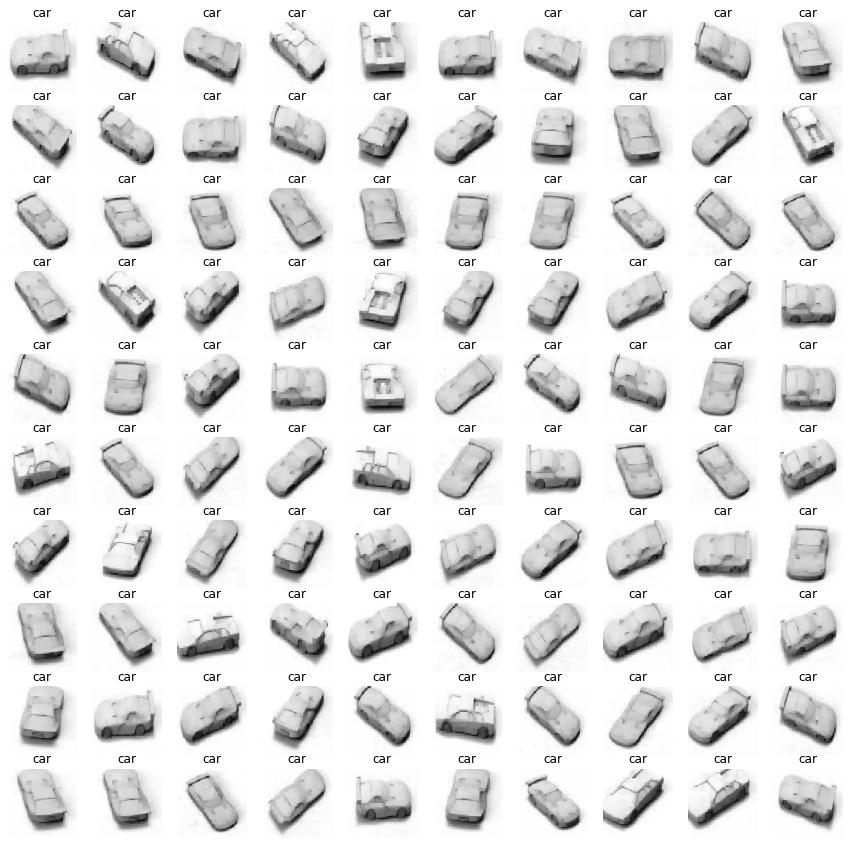

In [20]:
fig, axs = plt.subplots(10, 10,figsize=(15,15))

for i in range(10):
  for j in range(10):
    axs[i,j].imshow(train_images[i*10+j],cmap=plt.cm.gray)
    axs[i,j].set_title(lb.classes_[train_label_onehot[i*10+j].argmax()])
    axs[i,j].axis('off')

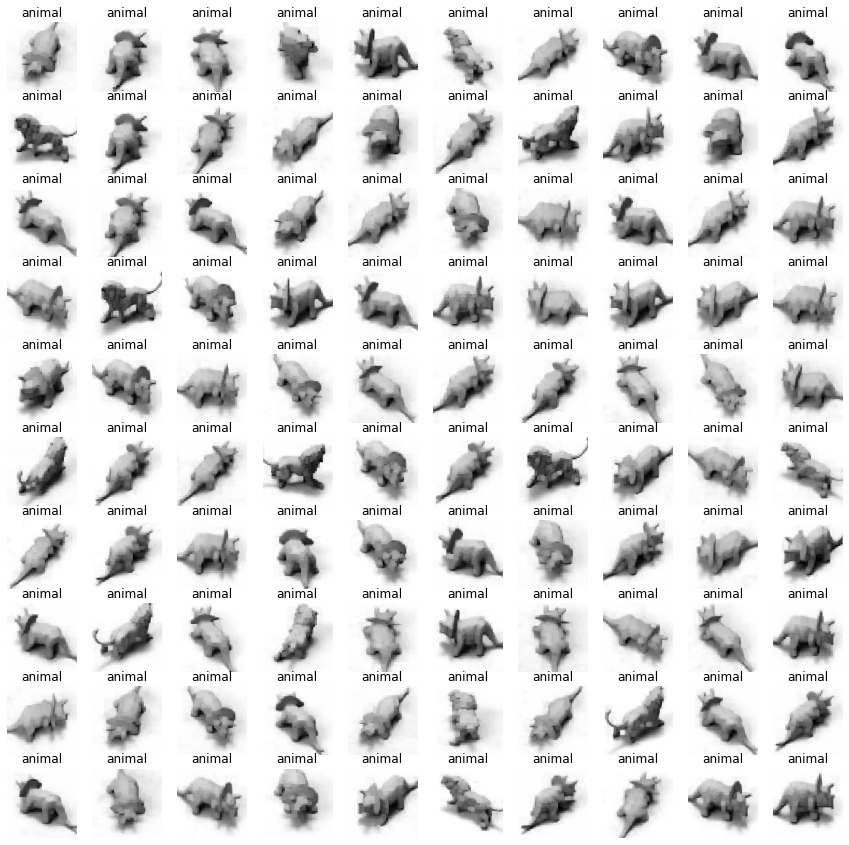

In [21]:
fig, axs = plt.subplots(10, 10,figsize=(15,15))

for i in range(10):
  for j in range(10):
    axs[i,j].imshow(train_images[200+i*10+j],cmap=plt.cm.gray)
    axs[i,j].set_title(lb.classes_[train_label_onehot[200+i*10+j].argmax()])
    axs[i,j].axis('off')

## Z-score normalizattion 

In [23]:
train_images_normalised = (train_images-val_images.mean())/val_images.std()
val_images_normalised = (val_images-val_images.mean())/val_images.std()
test_images_normalised = (test_images-val_images.mean())/val_images.std()

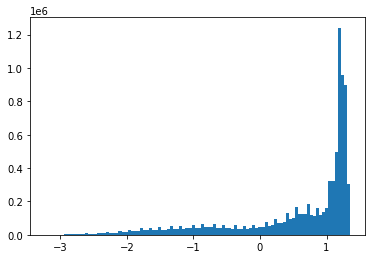

In [24]:
hist = plt.hist(train_images_normalised.flatten(),bins=100)

# Create the model and Train

In [25]:
checkpoint = ModelCheckpoint("model_{epoch:02d}-{val_loss:.2f}.hdf5",monitor='val_loss',verbose=1,save_best_only=True)
adaptiveLearningRate = ReduceLROnPlateau(monitor='loss',factor=0.1,patience=5,verbose=1,min_delta=0.0001)
earlyStopping = EarlyStopping(monitor='val_loss',mode='auto',verbose=1,patience=25)
callback_list = [checkpoint,adaptiveLearningRate,earlyStopping]

### Create the model

In [27]:
def get_model(input_shape,num_of_class,hidden_size1=128,hidden_size2=64,dropout=0.5):
  input = tf.keras.Input(shape=(96,96,1))
  x_skip = input
  x = L.Conv2D(filters=32,kernel_size=(7,7),strides=(1,1), padding = 'same')(input)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  x_skip = L.Conv2D(filters=32,kernel_size=(7,7),strides=(1,1), padding = 'same')(x_skip)
  x = L.Concatenate()([x, x_skip]) 
  x = L.MaxPool2D(pool_size=(2,2))(x)

  
  x_skip = x
  x = L.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1), padding = 'same')(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  x_skip = L.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1), padding = 'same')(x_skip)
  x = L.Concatenate()([x, x_skip]) 
  x = L.MaxPool2D(pool_size=(2,2))(x)

  
  x_skip = x
  x = L.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1), padding = 'same')(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x) 
  x_skip = L.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1), padding = 'same')(x_skip)
  x = L.Concatenate()([x, x_skip]) 
  x = L.MaxPool2D(pool_size=(2,2))(x)

  x_skip = x
  x = L.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1), padding = 'same')(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x) 
  x_skip = L.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1), padding = 'same')(x_skip)
  x = L.Concatenate()([x, x_skip]) 
  x = L.MaxPool2D(pool_size=(2,2))(x)


  x = L.Flatten()(x)
  x = L.Dense(hidden_size1)(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  x = L.Dropout(dropout)(x)  
  x = L.Dense(hidden_size2)(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  x = L.Dropout(dropout)(x)
  x = L.Dense(num_of_class,activation="softmax")(x)
  model = tf.keras.Model(input,x)
  return model

In [28]:
input_shape = (96,96,1)
num_of_class = len(lb.classes_)
K.clear_session()
tf.compat.v1.reset_default_graph()
model=get_model(input_shape,num_of_class)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=tf.keras.metrics.CategoricalAccuracy())
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   1600        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 96, 96, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 96, 96, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

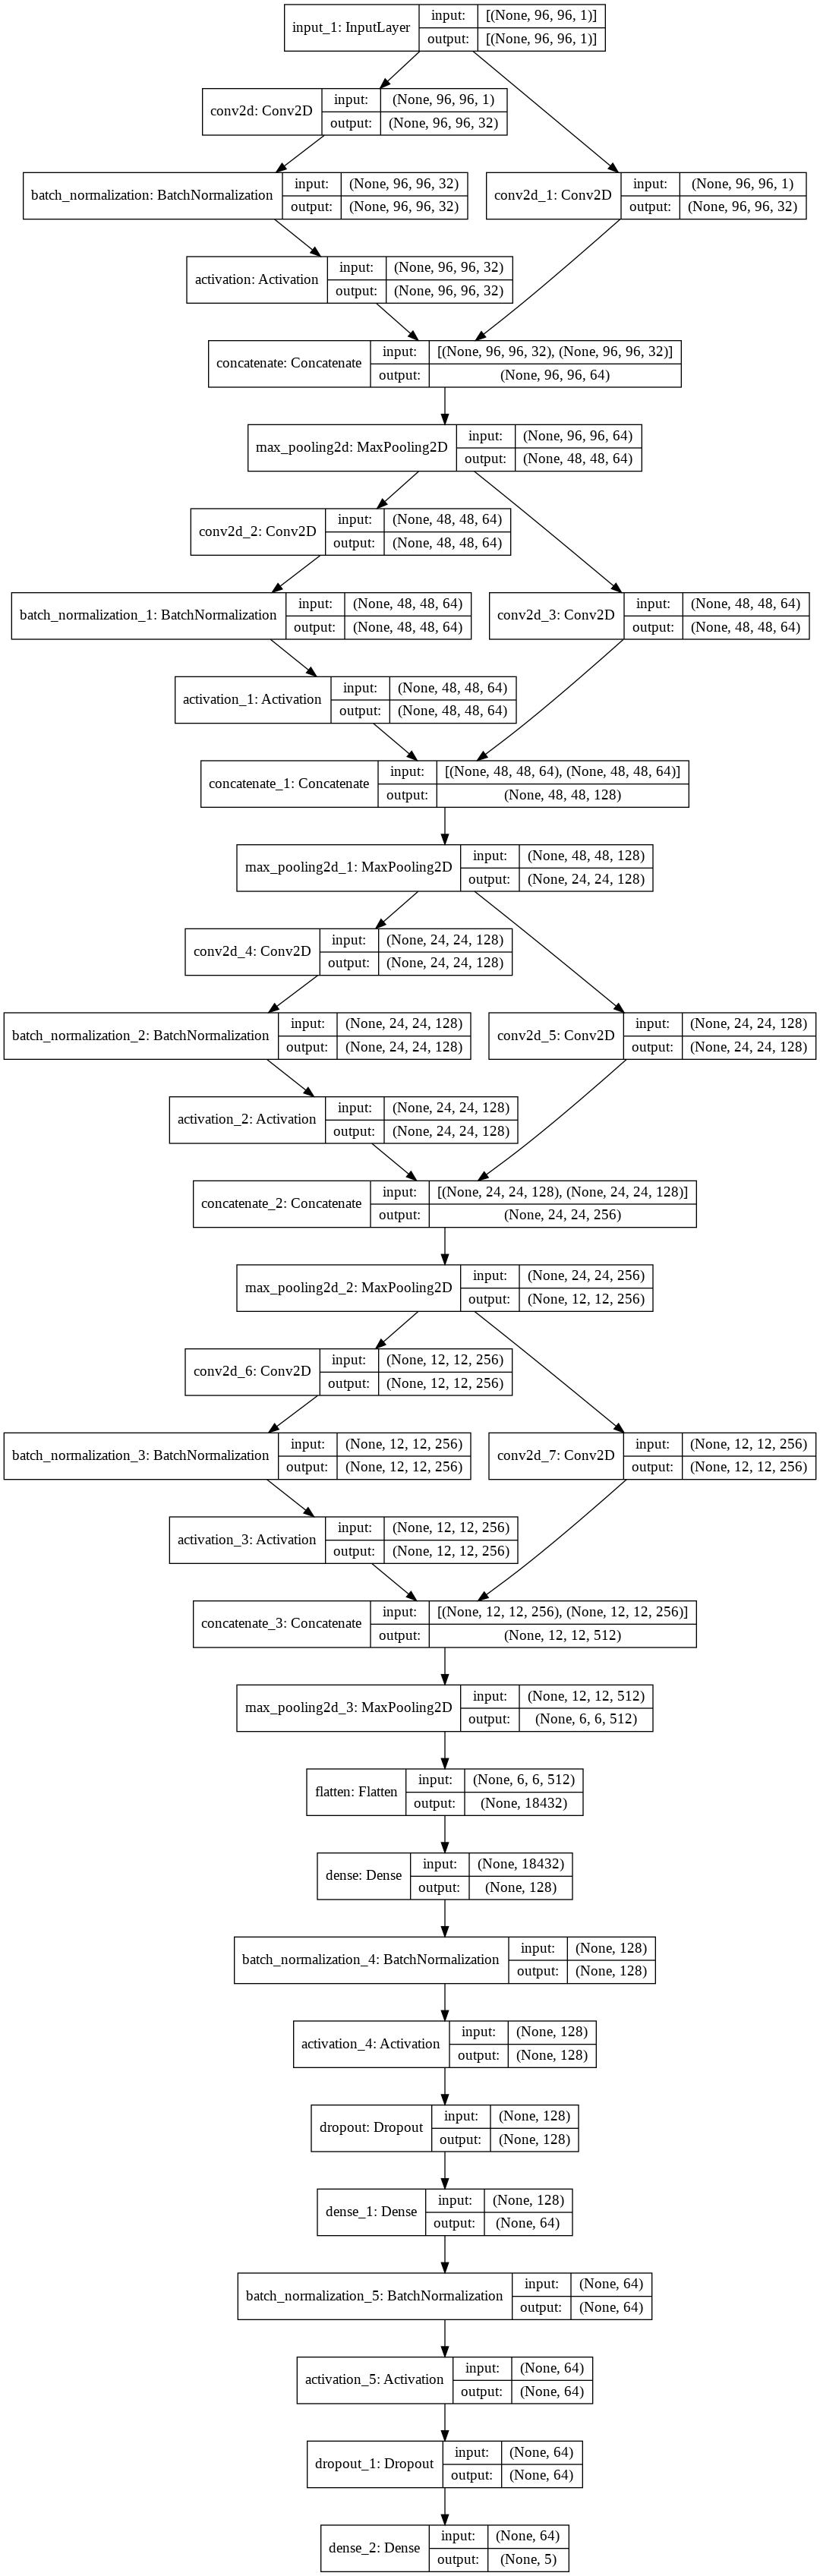

In [29]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [30]:
Augmented_training = ImageDataGenerator(rotation_range=2,
                                        fill_mode='nearest',
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        width_shift_range=0.01,
                                        height_shift_range=0.01)

### Train the model

__Note : The Val set was used as Train set and Train set was used as Val set as Val set had more data than Train set.__

_From now on Val set is treated as Trainset and train set is treated as Val set._

In [31]:
BATCH_SIZE = 64
EPOCHS = 200      
H = model.fit(
    Augmented_training.flow(np.expand_dims(val_images_normalised,3),val_label_onehot,batch_size=BATCH_SIZE),
    steps_per_epoch = len(np.expand_dims(val_images_normalised,3))//BATCH_SIZE,
    validation_data = (train_images_normalised,train_label_onehot),
    validation_steps=len(train_images_normalised)//BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = callback_list
)

Epoch 1/200
45/45 [==============================] - 12s 175ms/step - loss: 1.5033 - categorical_accuracy: 0.3907 - val_loss: 1.6477 - val_categorical_accuracy: 0.2515

Epoch 00001: val_loss improved from inf to 1.64765, saving model to model_01-1.65.hdf5
Epoch 2/200
45/45 [==============================] - 6s 142ms/step - loss: 1.0537 - categorical_accuracy: 0.5892 - val_loss: 1.9271 - val_categorical_accuracy: 0.2021

Epoch 00002: val_loss did not improve from 1.64765
Epoch 3/200
45/45 [==============================] - 6s 142ms/step - loss: 0.8895 - categorical_accuracy: 0.6550 - val_loss: 2.0772 - val_categorical_accuracy: 0.2021

Epoch 00003: val_loss did not improve from 1.64765
Epoch 4/200
45/45 [==============================] - 6s 143ms/step - loss: 0.7800 - categorical_accuracy: 0.7003 - val_loss: 1.9895 - val_categorical_accuracy: 0.2247

Epoch 00004: val_loss did not improve from 1.64765
Epoch 5/200
45/45 [==============================] - 7s 145ms/step - loss: 0.6976 - cat

In [32]:
model.history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

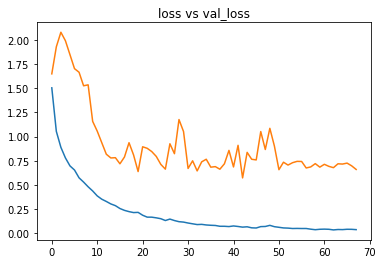

In [33]:
fig=plt.figure()
plt.plot(model.history.history["loss"],label="loss")
plt.plot(model.history.history["val_loss"],label="val_loss")
plt.title("loss vs val_loss")
plt.show()

## Classification report on the data on which model was trained

In [34]:
prediction = model.predict(val_images_normalised)
print("Train classification report")
print(classification_report(val_label_onehot.argmax(axis=1),prediction.argmax(axis=1),target_names=lb.classes_))

Train classification report
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00       582
      animal       1.00      1.00      1.00       582
         car       1.00      1.00      1.00       582
       human       1.00      1.00      1.00       582
       truck       1.00      1.00      1.00       582

    accuracy                           1.00      2910
   macro avg       1.00      1.00      1.00      2910
weighted avg       1.00      1.00      1.00      2910



## Classification report on the data on which model was Validated

In [35]:
prediction = model.predict(train_images_normalised)
print("Val classification report")
print(classification_report(train_label_onehot.argmax(axis=1),prediction.argmax(axis=1),target_names=lb.classes_))

Val classification report
              precision    recall  f1-score   support

    airplane       0.85      0.80      0.83       194
      animal       0.79      0.66      0.72       194
         car       0.77      0.85      0.81       194
       human       0.80      0.76      0.78       194
       truck       0.70      0.82      0.75       194

    accuracy                           0.78       970
   macro avg       0.78      0.78      0.78       970
weighted avg       0.78      0.78      0.78       970



In [36]:
prediction = model.predict(test_images_normalised)

# Test result visulation on Test data set

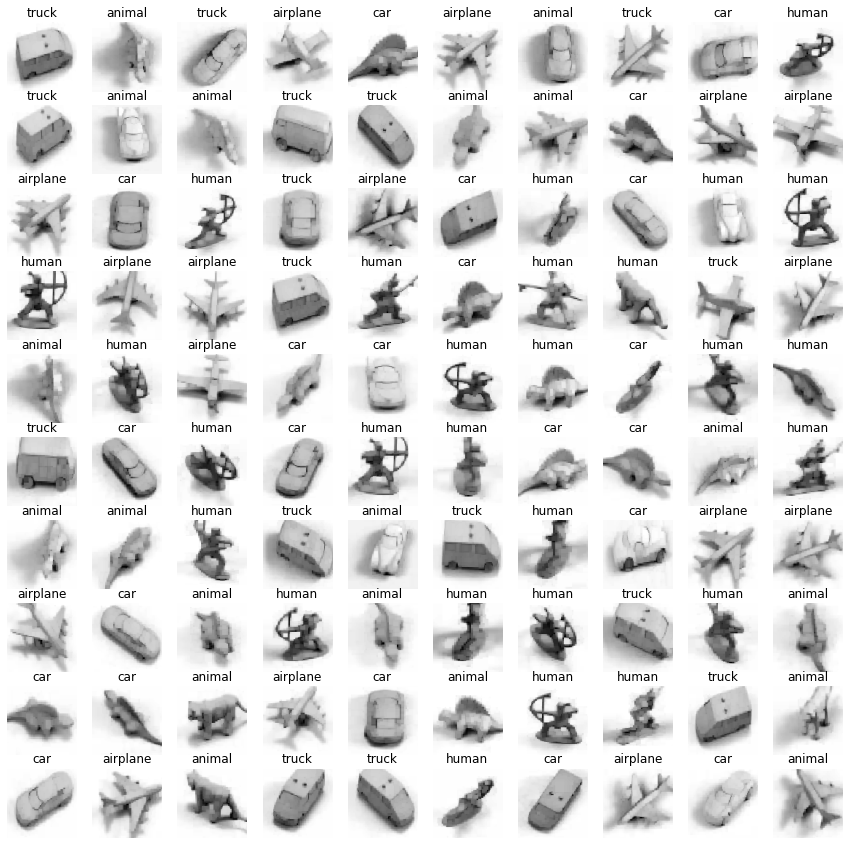

In [37]:
fig, axs = plt.subplots(10, 10,figsize=(15,15))
for i in range(10):
  for j in range(10):
    axs[i,j].imshow(test_images[i*10+j],cmap=plt.cm.gray)
    axs[i,j].set_title(lb.classes_[prediction[i*10+j].argmax()])
    axs[i,j].axis('off')

In [38]:
import pandas as pd

In [39]:
data = []
for i,path in enumerate(test_images_path):
  data.append([path.split(os.sep)[-1],lb.classes_[prediction[i].argmax()]])


In [40]:
df = pd.DataFrame(data=data,columns=['Image_Name','Label'])

In [41]:
df.head()

,Image_Name,Label
0,036298_02_lt.jpg,truck
1,037190_02_lt.jpg,animal
2,038784_02_lt.jpg,truck
3,039772_03_lt.jpg,airplane
4,034105_02_lt.jpg,car


In [46]:
df.to_csv("Submission1.csv")

In [47]:
model.save("last_weight.hdf5")

In [50]:
!ls

drive		    model_11-1.06.hdf5	model_20-0.64.hdf5     Submission1.csv
last_weight.hdf5    model_12-0.94.hdf5	model_43-0.57.hdf5     Test_data
model_01-1.65.hdf5  model_13-0.82.hdf5	model.png
model_08-1.52.hdf5  model_14-0.78.hdf5	sample_data
model_10-1.16.hdf5  model_16-0.72.hdf5	Sample_Submission.csv
